## More Plot Types — Advanced Practice (with Solutions)

This notebook contains **advanced (but not too much)** Matplotlib practice problems **with solutions**.

Best practices used throughout:
- Reproducible random seeds
- Clear axis labels, titles, legends
- Consistent units + readable tick formatting
- Avoiding duplicated code via small helper functions
- Sanity checks (assertions) to catch mistakes early


### Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Style & defaults
mpl.style.use('seaborn-v0_8-dark')
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['axes.titlepad'] = 12

np.random.seed(42)

def format_thousands(ax=None, axis='y'):
    """Format ticks with thousands separators."""
    ax = ax or plt.gca()
    fmt = mpl.ticker.StrMethodFormatter('{x:,.0f}')
    if axis == 'y':
        ax.yaxis.set_major_formatter(fmt)
    elif axis == 'x':
        ax.xaxis.set_major_formatter(fmt)
    else:
        raise ValueError("axis must be 'x' or 'y'")
    return ax

def add_grid(ax=None, which='major', alpha=0.25):
    ax = ax or plt.gca()
    ax.grid(True, which=which, alpha=alpha)
    return ax

### Create example datasets (no external files needed)

We will use:
- A small "state-like" population dataset
- A synthetic time series dataset
- Synthetic distributions for histogram/box/violin practice


In [2]:
# "State-like" populations
states = [
    'California', 'Texas', 'Florida', 'New York', 'Pennsylvania',
    'Illinois', 'Ohio', 'Georgia', 'North Carolina', 'Michigan',
    'New Jersey', 'Virginia', 'Washington', 'Arizona', 'Massachusetts'
]

# Create a descending-ish population profile (in people)
base = np.linspace(39_000_000, 6_800_000, num=len(states))
noise = np.random.normal(0, 600_000, size=len(states))
pop_2001 = np.maximum(500_000, (base + noise).astype(int))

df_pop = pd.DataFrame({
    'State': states,
    'Population_2001': pop_2001
}).sort_values('Population_2001', ascending=False).reset_index(drop=True)

df_pop.head()

,State,Population_2001
0,California,39298028
1,Texas,36617041
2,Florida,34788613
3,New York,33013817
4,Pennsylvania,29659507


In [3]:
# Time series dataset: 36 months of synthetic metrics
dates = pd.date_range('2022-01-01', periods=36, freq='MS')
trend = np.linspace(100, 165, len(dates))
season = 8 * np.sin(np.linspace(0, 6*np.pi, len(dates)))
noise = np.random.normal(0, 4.0, len(dates))

metric_a = trend + season + noise
metric_b = 0.85 * trend + 0.5 * season + np.random.normal(0, 3.5, len(dates))

df_ts = pd.DataFrame({
    'date': dates,
    'metric_a': metric_a,
    'metric_b': metric_b,
})

df_ts.head()

,date,metric_a,metric_b
0,2022-01-01,97.750850,83.652212
1,2022-02-01,101.909013,86.260942
2,2022-03-01,112.016039,93.820392
3,2022-04-01,109.931277,97.340185
4,2022-05-01,108.455943,97.912059


In [4]:
# Distributions for histogram/box/violin
n = 50_000
dist_normal = np.random.normal(loc=0, scale=1, size=n)
dist_lognorm = np.random.lognormal(mean=0.05, sigma=0.55, size=n)  # skewed
dist_bimodal = np.concatenate([
    np.random.normal(-1.4, 0.55, size=n//2),
    np.random.normal(1.0, 0.75, size=n//2)
])

# Quick sanity checks
assert len(dist_normal) == n
assert len(dist_lognorm) == n
assert len(dist_bimodal) == n

np.percentile(dist_bimodal, [5, 50, 95])

array([-2.10108439, -0.37695149,  1.97020761])

# Problem 1 — Ranked bar chart with unit scaling + annotations

**Task**
1. Create a bar chart of state populations ranked from largest to smallest.
2. Plot population in **millions**.
3. Annotate the **top 3** bars with their values (e.g., `39.2M`).
4. Rotate x labels for readability.

**Goal**: practice clean categorical plotting, scaling, and annotations.

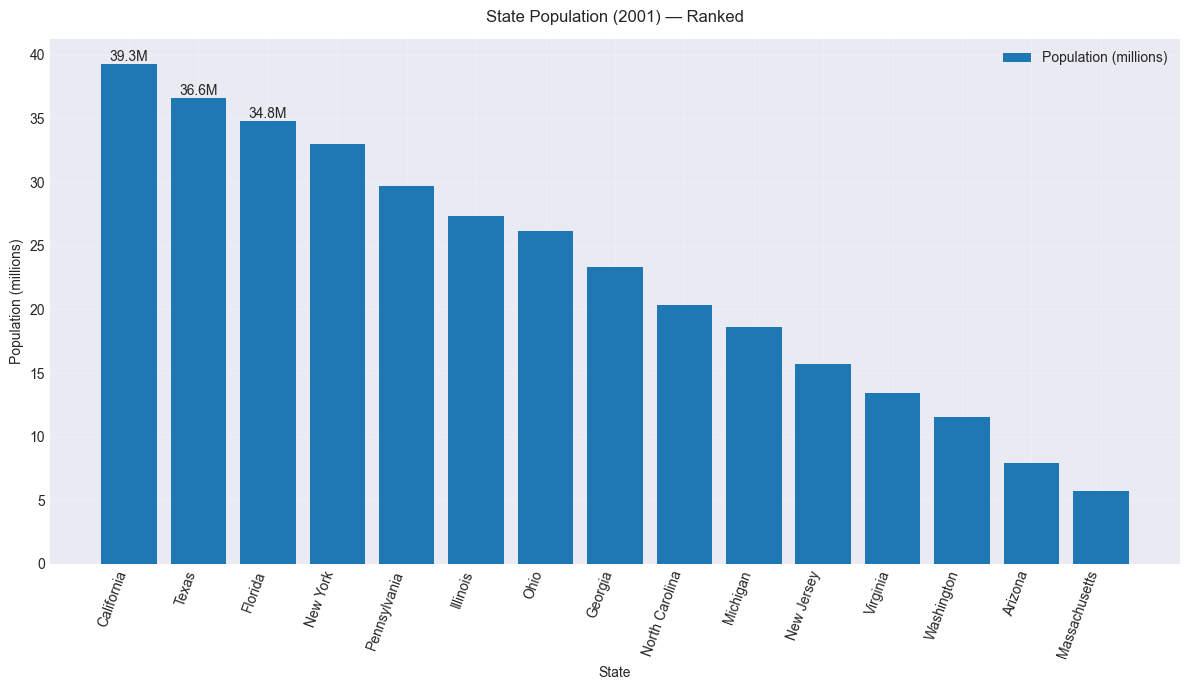

In [5]:
# SOLUTION
data = df_pop.copy()
data['pop_millions'] = data['Population_2001'] / 1_000_000

fig, ax = plt.subplots()
bars = ax.bar(data['State'], data['pop_millions'], label='Population (millions)')

ax.set_title('State Population (2001) — Ranked')
ax.set_xlabel('State')
ax.set_ylabel('Population (millions)')
plt.xticks(rotation=70, ha='right')

# Annotate top 3
for i in range(3):
    b = bars[i]
    val = b.get_height()
    ax.text(
        b.get_x() + b.get_width()/2,
        val,
        f"{val:.1f}M",
        ha='center', va='bottom'
    )

ax.legend()
add_grid(ax, alpha=0.2)
plt.tight_layout()

# Check ordering is descending
assert data['Population_2001'].is_monotonic_decreasing

# Problem 2 — Horizontal bar chart + highlighting + top-N subset

**Task**
1. Plot the **top 10** states as a **horizontal bar** chart.
2. Highlight one chosen state (e.g., `Texas`) by changing its appearance.
3. Add a vertical grid and format x-axis with thousands separators.

**Goal**: better readability for many categories + selective emphasis.

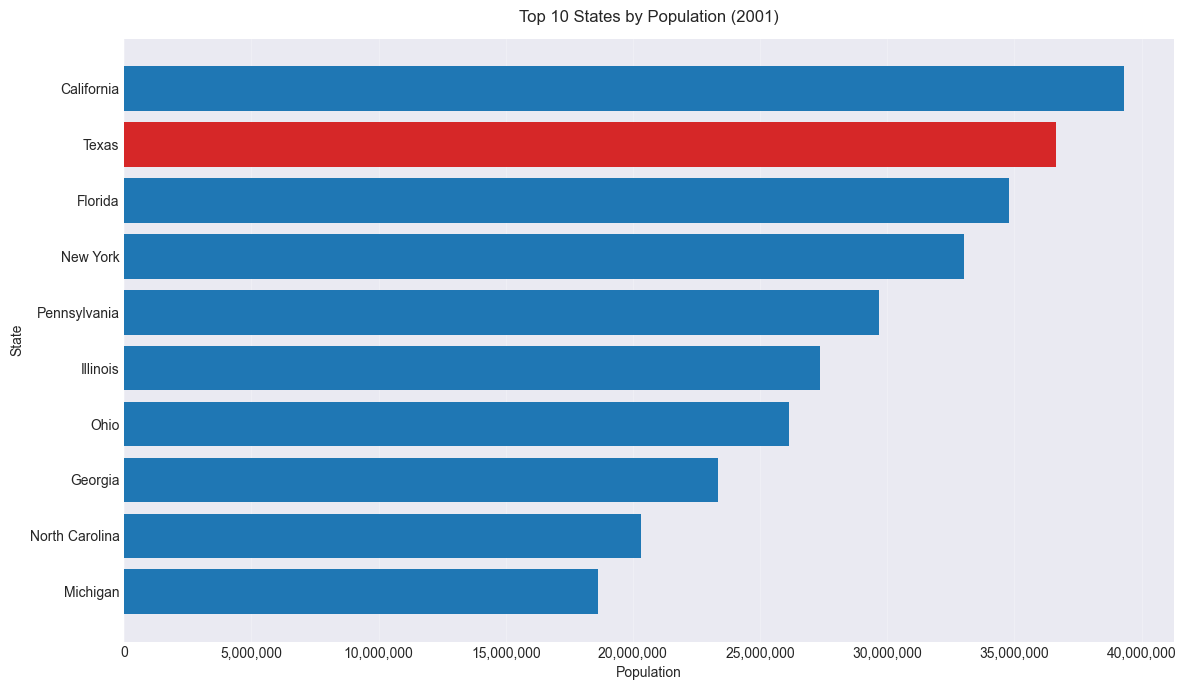

In [6]:
# SOLUTION
top_n = 10
highlight = 'Texas'

top = df_pop.head(top_n).copy()

fig, ax = plt.subplots()
colors = ['C0'] * len(top)
if highlight in top['State'].values:
    colors[top.index[top['State'] == highlight][0]] = 'C3'

ax.barh(top['State'], top['Population_2001'], color=colors)
ax.invert_yaxis()  # largest at top

ax.set_title(f'Top {top_n} States by Population (2001)')
ax.set_xlabel('Population')
ax.set_ylabel('State')

format_thousands(ax, axis='x')
ax.grid(True, axis='x', alpha=0.25)
plt.tight_layout()

# Sanity check: highlight exists in all states; and top is sorted
assert highlight in df_pop['State'].values
assert top['Population_2001'].is_monotonic_decreasing

# Problem 3 — Multi-series time plot + rolling average + shaded band

**Task**
1. Plot `metric_a` and `metric_b` over time (same axes).
2. Add a **6-month rolling mean** for `metric_a`.
3. Add a shaded band showing `metric_a ± 1 std` (use a **rolling std**).
4. Use good labeling and a legend.

**Goal**: time-series layering and uncertainty visualization.

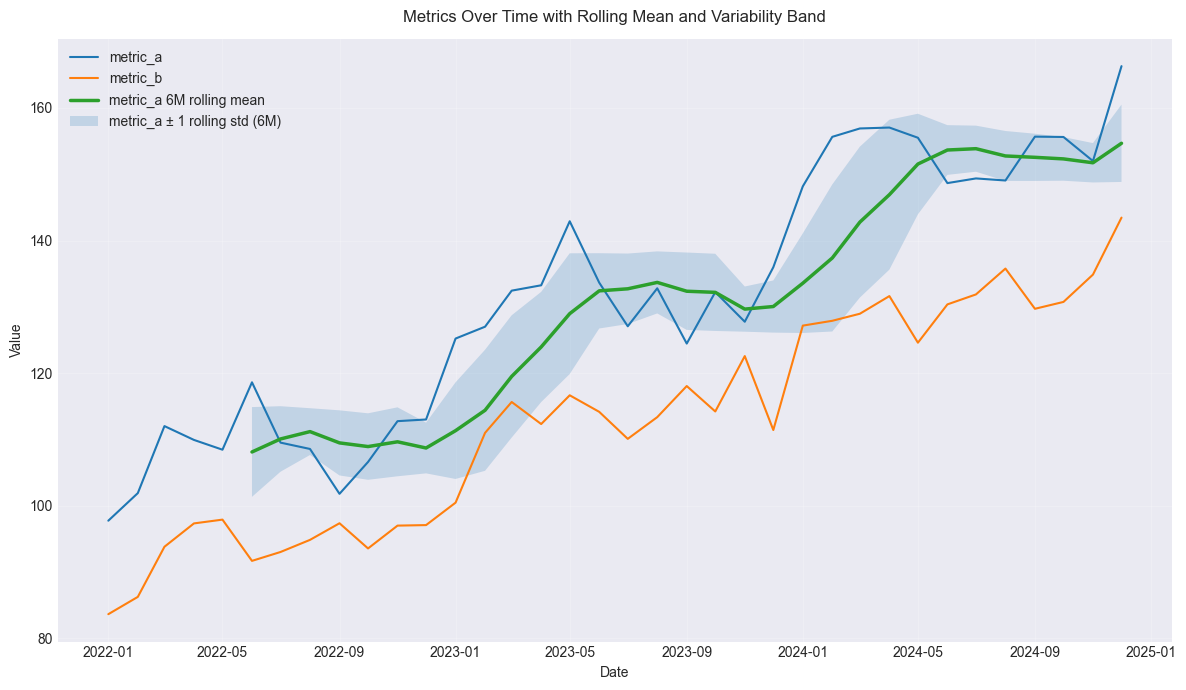

In [7]:
# SOLUTION
ts = df_ts.copy().set_index('date')

window = 6
a_roll = ts['metric_a'].rolling(window=window, min_periods=window).mean()
a_std = ts['metric_a'].rolling(window=window, min_periods=window).std(ddof=0)

fig, ax = plt.subplots()
ax.plot(ts.index, ts['metric_a'], label='metric_a', linewidth=1.5)
ax.plot(ts.index, ts['metric_b'], label='metric_b', linewidth=1.5)
ax.plot(ts.index, a_roll, label=f'metric_a {window}M rolling mean', linewidth=2.5)

# Shaded band (only where rolling stats exist)
mask = a_roll.notna() & a_std.notna()
ax.fill_between(
    ts.index[mask],
    (a_roll - a_std)[mask],
    (a_roll + a_std)[mask],
    alpha=0.2,
    label=f'metric_a ± 1 rolling std ({window}M)'
)

ax.set_title('Metrics Over Time with Rolling Mean and Variability Band')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
add_grid(ax, alpha=0.2)
plt.tight_layout()

# Sanity checks
assert a_roll.dropna().shape[0] == len(ts) - (window - 1)
assert (mask.sum() == len(ts) - (window - 1))

# Problem 4 — Histogram best practices: bins, density, and percentiles

**Task**
1. Plot histograms for `dist_normal` and `dist_bimodal` on the same axes.
2. Use `density=True` so the y-axis is comparable.
3. Add vertical lines for the 10th, 50th, and 90th percentiles of each distribution.
4. Use transparency so overlap is readable.

**Goal**: compare distributions properly and mark summary statistics.

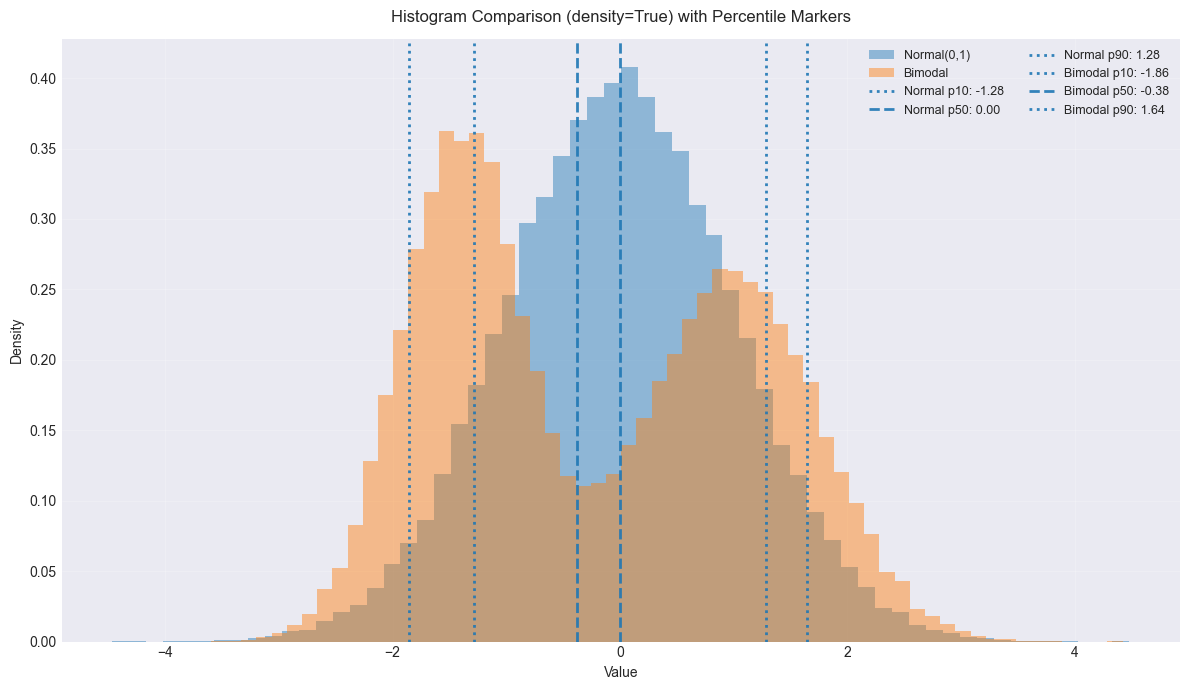

In [8]:
# SOLUTION
fig, ax = plt.subplots()

bins = 60

ax.hist(dist_normal, bins=bins, density=True, alpha=0.45, label='Normal(0,1)')
ax.hist(dist_bimodal, bins=bins, density=True, alpha=0.45, label='Bimodal')

def add_percentile_lines(ax, data, label_prefix, ls_map=None):
    ls_map = ls_map or {10: ':', 50: '--', 90: ':'}
    for p in (10, 50, 90):
        x = np.percentile(data, p)
        ax.axvline(x, linestyle=ls_map[p], linewidth=2, alpha=0.9,
                   label=f'{label_prefix} p{p}: {x:.2f}')

add_percentile_lines(ax, dist_normal, 'Normal')
add_percentile_lines(ax, dist_bimodal, 'Bimodal')

ax.set_title('Histogram Comparison (density=True) with Percentile Markers')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend(ncol=2, fontsize=9)
add_grid(ax, alpha=0.2)
plt.tight_layout()

# Sanity check: median lines are near expected centers
assert abs(np.percentile(dist_normal, 50)) < 0.05  # close to 0 for large n

# Problem 5 — Box plot and violin plot: compare distribution shape

**Task**
1. Create a **box plot** comparing `dist_normal`, `dist_lognorm`, and `dist_bimodal`.
2. Create a **violin plot** for the same data.
3. For both plots, label categories and add an informative title.

**Goal**: understand how box vs violin communicates distribution properties (skew, multimodality).

C:\Users\user1\AppData\Local\Temp\ipykernel_1584\1621721472.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(datasets, labels=labels, showmeans=True)


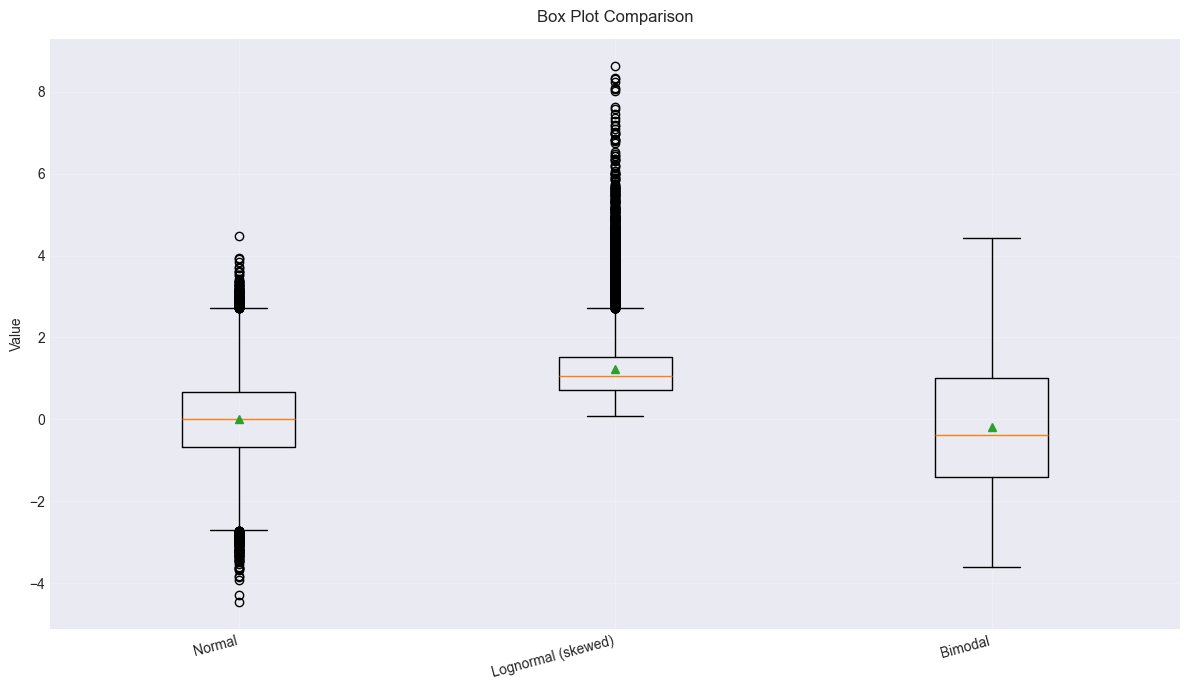

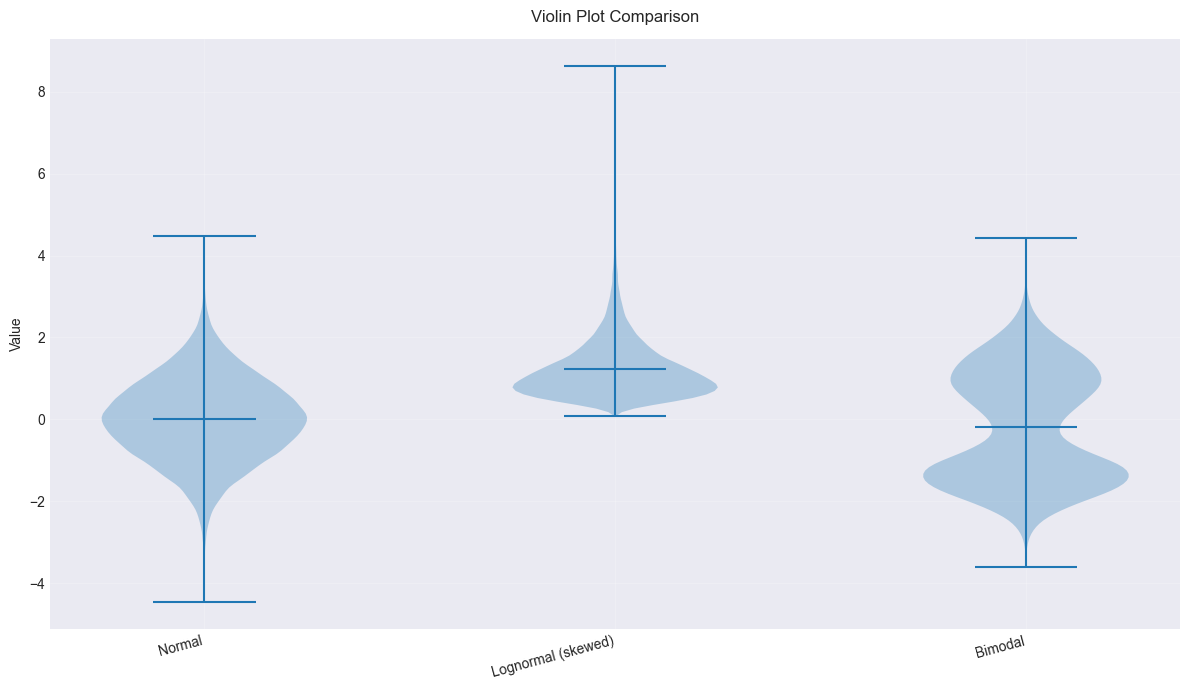

In [9]:
# SOLUTION
datasets = [dist_normal, dist_lognorm, dist_bimodal]
labels = ['Normal', 'Lognormal (skewed)', 'Bimodal']

fig, ax = plt.subplots()
ax.boxplot(datasets, labels=labels, showmeans=True)
ax.set_title('Box Plot Comparison')
ax.set_ylabel('Value')
plt.xticks(rotation=15, ha='right')
add_grid(ax, alpha=0.2)
plt.tight_layout()

fig, ax = plt.subplots()
vp = ax.violinplot(datasets, showmeans=True, showextrema=True)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels, rotation=15, ha='right')
ax.set_title('Violin Plot Comparison')
ax.set_ylabel('Value')
add_grid(ax, alpha=0.2)
plt.tight_layout()

# Sanity checks: lognormal should be mostly positive; bimodal median should be between modes
assert np.mean(dist_lognorm > 0) > 0.99
assert -0.5 < np.percentile(dist_bimodal, 50) < 0.5

# Problem 6 — Scatter plot with colormap + colorbar + size encoding

**Task**
Create a scatter plot for synthetic "cities":
- x = longitude-like feature
- y = latitude-like feature
- point color = population
- point size = population (scaled)
- include a colorbar

**Goal**: multivariate scatter using color + size + colorbar.

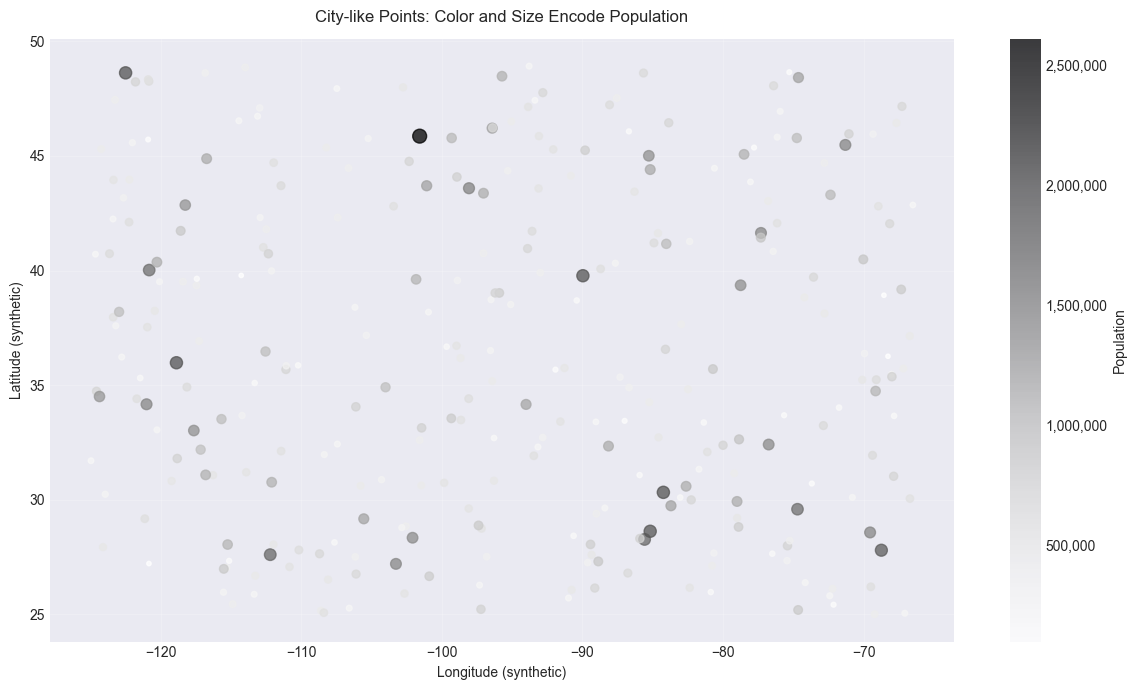

In [10]:
# SOLUTION
m = 300
lon = np.random.uniform(-125, -66, size=m)
lat = np.random.uniform(25, 49, size=m)

# Population: wide range (simulate using lognormal)
pop = np.random.lognormal(mean=13.2, sigma=0.6, size=m)  # roughly in the 10^5 to 10^7 range
pop = np.clip(pop, 80_000, 25_000_000)

# Size scaling: keep reasonable for display
sizes = 10 + 90 * (pop - pop.min()) / (pop.max() - pop.min())

fig, ax = plt.subplots()
sc = ax.scatter(lon, lat, c=pop, s=sizes, alpha=0.75)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Population')
cbar.formatter = mpl.ticker.StrMethodFormatter('{x:,.0f}')
cbar.update_ticks()

ax.set_title('City-like Points: Color and Size Encode Population')
ax.set_xlabel('Longitude (synthetic)')
ax.set_ylabel('Latitude (synthetic)')
add_grid(ax, alpha=0.2)
plt.tight_layout()

assert lon.shape == lat.shape == pop.shape == (m,)

# Problem 7 — Hexbin plot vs scatter: handle overplotting

**Task**
1. Create a scatter plot of `dist_normal` vs `dist_normal` with noise (a dense cloud).
2. Create a **hexbin** plot of the same data.
3. Add a colorbar to the hexbin plot.

**Goal**: learn a better alternative when scatter points overlap heavily.

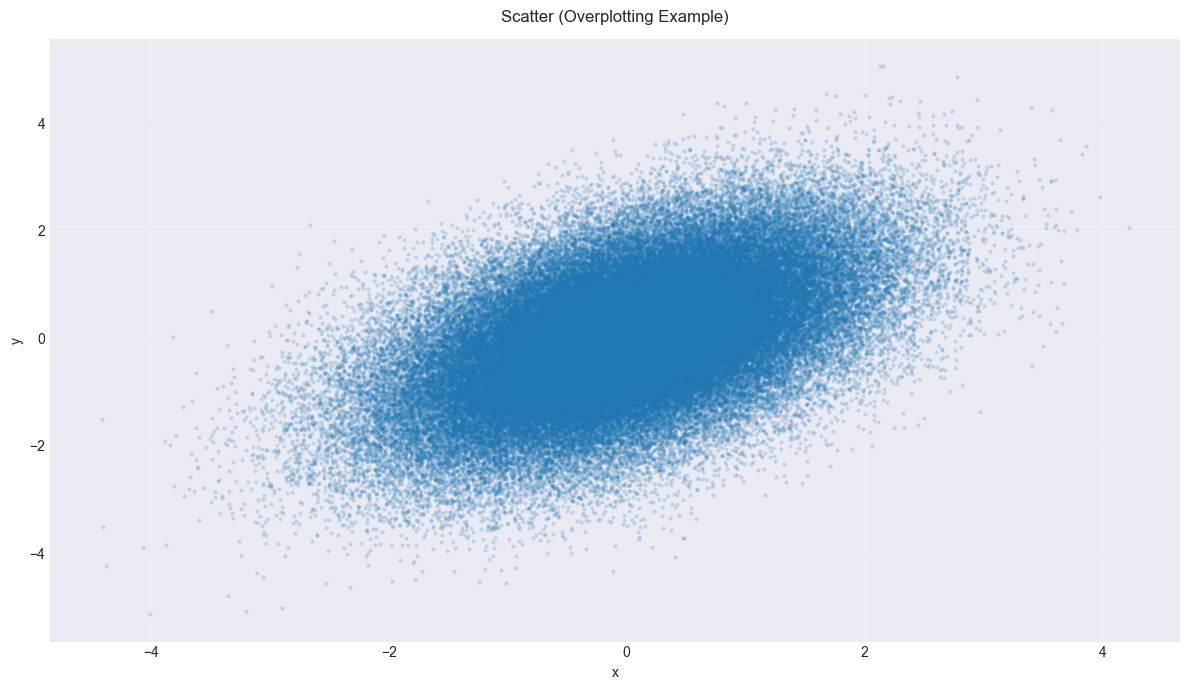

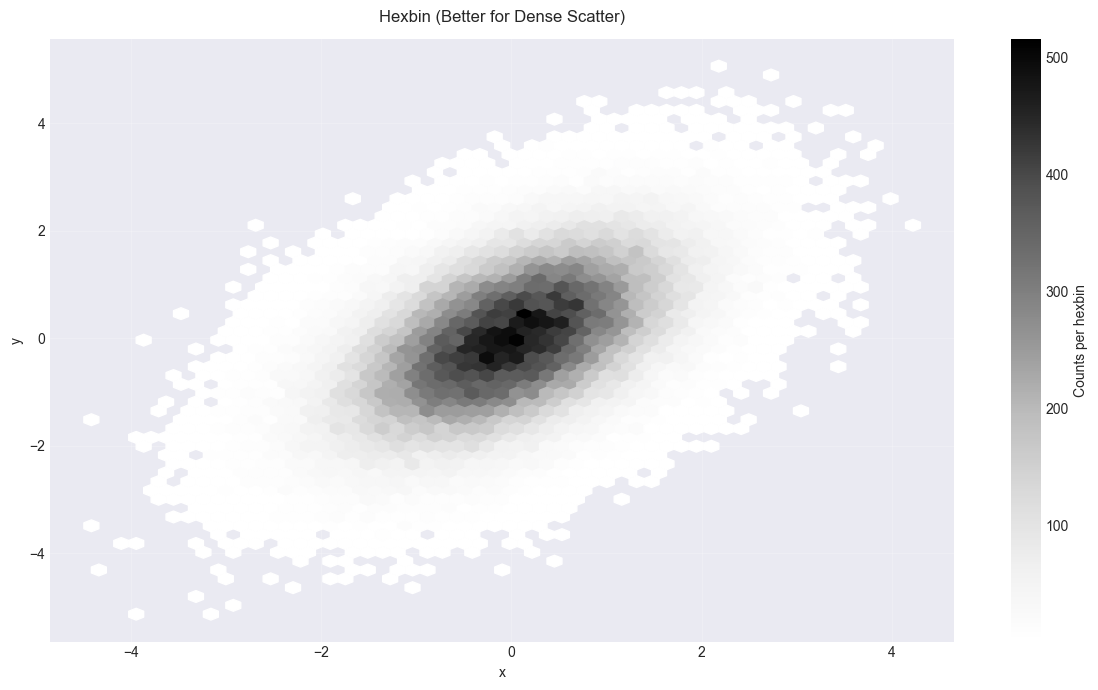

In [11]:
# SOLUTION
k = 120_000
x = np.random.normal(0, 1, size=k)
y = 0.6 * x + np.random.normal(0, 1, size=k)

fig, ax = plt.subplots()
ax.scatter(x, y, s=4, alpha=0.15)
ax.set_title('Scatter (Overplotting Example)')
ax.set_xlabel('x')
ax.set_ylabel('y')
add_grid(ax, alpha=0.2)
plt.tight_layout()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=55, mincnt=1)
cbar = plt.colorbar(hb, ax=ax)
cbar.set_label('Counts per hexbin')

ax.set_title('Hexbin (Better for Dense Scatter)')
ax.set_xlabel('x')
ax.set_ylabel('y')
add_grid(ax, alpha=0.2)
plt.tight_layout()

assert k == len(x) == len(y)

# Problem 8 — Two y-axes (twinx) done responsibly

**Task**
Use the time series data and:
1. Plot `metric_a` on the left y-axis.
2. Plot a derived metric on the right y-axis: `ratio = metric_a / metric_b`.
3. Use different line styles and make the legend readable.

**Goal**: practice `twinx()` without making the chart confusing.

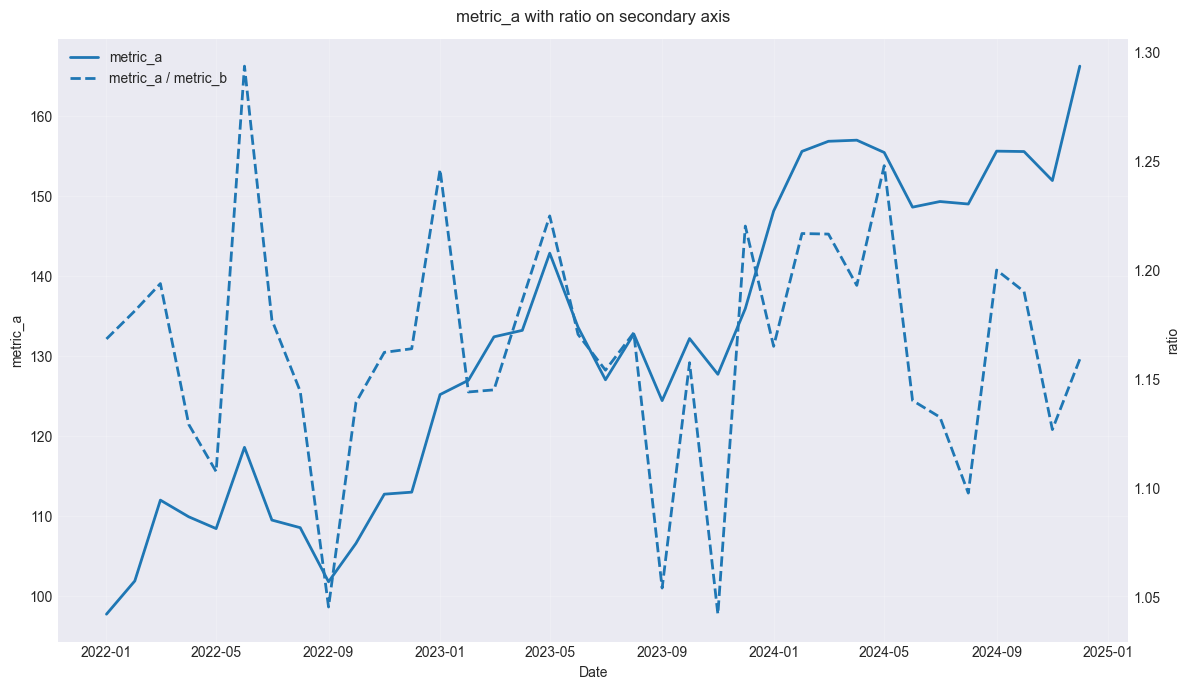

In [12]:
# SOLUTION
ts = df_ts.copy().set_index('date')
ratio = ts['metric_a'] / ts['metric_b']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.plot(ts.index, ts['metric_a'], linewidth=2, label='metric_a')
l2 = ax2.plot(ts.index, ratio, linewidth=2, linestyle='--', label='metric_a / metric_b')

ax1.set_title('metric_a with ratio on secondary axis')
ax1.set_xlabel('Date')
ax1.set_ylabel('metric_a')
ax2.set_ylabel('ratio')

# Combine legends from both axes
lines = l1 + l2
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc='upper left')

add_grid(ax1, alpha=0.2)
plt.tight_layout()

# Sanity checks
assert np.isfinite(ratio).all()
assert ratio.mean() > 0